In [23]:
import pandas as pd
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import numpy as np
from src.pandas_multi_df import build_df, timeit_context, operate_pandas, operate_pytorch
import time
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


In [34]:
def plot(data: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 10))
    for method in data['method'].unique():
        method_data = data[data['method'] == method]
        plt.plot(method_data['row_count'], method_data['duration'],
                 marker='o',
                 label=method.upper(),
                 linewidth=2,
                 markersize=8)

    plt.xlabel('Row Count')
    plt.ylabel('Duration (seconds)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()




In [39]:
np.random.seed(0)
column_count = 500
row_count = 400
time_data = dict()
row_tests = [i for i in range(0, row_count, 50)]
#row_tests = [10]
methods = ['cpu', 'gpu']

time_data = {
    'method': [],
    'duration': [],
    'row_count': [],
    'column_count': [],
}
for row_num in row_tests:
    df1 = build_df(row_num, 0, 10, column_count + 3)
    df2 = build_df(row_num, 0, 10, column_count)
    for method in methods:
        start_time = time.perf_counter()
        operate_pytorch(df1, df2, use_gpu=method == "gpu")
        total_time = time.perf_counter() - start_time
        time_data['method'].append(method)
        time_data['row_count'].append(row_num)
        time_data['duration'].append(total_time)
        time_data['column_count'].append(column_count)
all_data = pd.DataFrame(time_data)

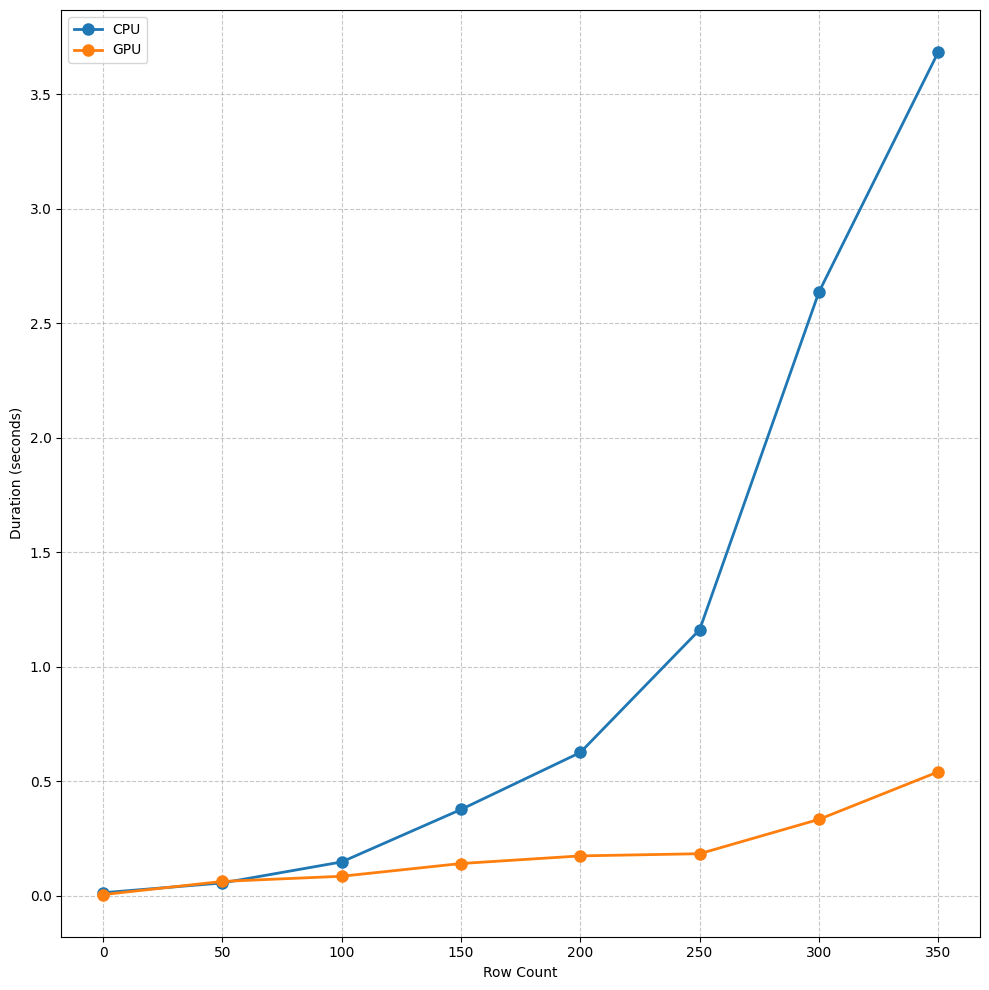

In [40]:
plot(all_data)